# Chapter 7. Function Decorators and Closures 

## Decorators 101

* A decorator is a collable that takes another function as argument (the decoreated function)

**Example from Udemy Python Bootcamp**

In [8]:
def new_decorator(original_func):
    
    def wrap_func():
        
        print('Some extra code, before original_func')
        
        original_func()
        
        print('Some extra code, after original_func')
        
    return wrap_func()

In [9]:
@new_decorator

def func_needs_decorator():
    print('I want to be decorated!')

Some extra code, before original_func
I want to be decorated!
Some extra code, after original_func


**Example 7-1.** A decorator usually replaces a function with a different one. 

In [10]:
def deco(func):
    
    def inner():
        print('running inner()')
        
    return inner  # deco returns its inner function object 

In [11]:
@deco
def target(): # target is decorated by deco 
    print('running target()')

In [12]:
# Invoking the decorated target actually runs inner. 
target() 

running inner()


In [13]:
target

<function __main__.deco.<locals>.inner()>

**The two crucial fact about decorators**:

* Decorators have the power to replace the decorated function with a different one. 
* Decorators are executed immediately when a module is loaded.

## When Python Executes Decorators 

* A key feature of decorators is that they run right after the decorated function is defined. 

**Example 7-2.** The registration.py module

In [14]:
# registry will hold references to functions decorated by @register 
registry = []

In [15]:
def register(func): # register takes a function as argument
    
    print('running register(%s) % func')# Display what function is being decorated
    registry.append(func)# Include func in registry
    return func # we must return a function; here we return the same received as argument 

In [18]:
@register # f1 and f2 are decorated by @register
def f1():
    print('running f1()')

running register(%s) % func


In [19]:
@register
def f2():
    print('running f2()')

running register(%s) % func


In [20]:
def f3(): # f3 is not decorated 
    print('running f3()')

In [25]:
def main(): # main displays the registry, then calls f1(),f2(), and f3()
    print('running main()')
    print('registry ->', registry)
    f1()
    f2()
    f3()

if __name__=='__main__':
    main() # main() is only invoked if registration.py runs as a script. 

running main()
registry -> [<function f1 at 0x7f9b95b74310>, <function f1 at 0x7f9b95d5bca0>, <function f2 at 0x7f9b95b74670>, <function f1 at 0x7f9b95b74700>, <function f2 at 0x7f9b95b74550>]
running f1()
running f2()
running f3()


**Example 7-3.** The promos list is filled by the promotion decorator

In [26]:
promos = [] # The promos list starts empty 

In [27]:
def promotion(promo_func): # promotion decorator returns promo_func unchanged
    # after adding it to the promos list 
    
    promos.append(promo_func)
    return promo_func

In [29]:
@promotion # Any function decorated by @promotion will be added to promos

def fidelity(order):
    
    """5% discount for customers with 1000 or more fidelity points"""
    
    return order.total()*0.05 if order.customer.fidelity >= 1000 else 0 

In [30]:
@promotion 

def bulk_item(order):
    
    """10% discount for each LineItem with 20 or more units"""
    
    discount = 0
    for item in order.cart:
        if item.quantity >=20:
            discount += item.total() *0.1
    return discount 

In [31]:
@promotion

def large_order(order):
    
    """7% discount for orders with 10 or more distinct items"""
    
    distinct_items = {item.product for item in order.cart}
    
    if len(distinct_items) >=10:
        return order.total()*0.07
    return 0 

In [32]:
def best_promo(order): # no changes needed to best_promos, b/c it relies on the promos list 
    
    """Select best discount available"""
    
    return max(promo(order) for promo in promos)

## Closures

**Example 7-8.** average_oo.py: A class to calculate a running average.

In [36]:
class Avergaer():
    
    def __init__(self):
        self.series = []
        
    def __call__(self, new_value):
        self.series.append(new_value)
        total = sum(self.series)
        return total/len(self.series)

In [38]:
avg = Avergaer()

In [40]:
avg(10)

10.0

In [41]:
avg(11)

10.5

In [42]:
avg(12)

11.0

**Example 7-9.** A higher-order function to calculate a running average

In [44]:
def make_averager():
    
    series = []
    
    def averager(new_value):
        series.append(new_value)
        total = sum(series)
        return total/len(series)
    
    return averager

In [45]:
avg = make_averager()

In [46]:
avg(10)

10.0

In [47]:
avg(11)

10.5

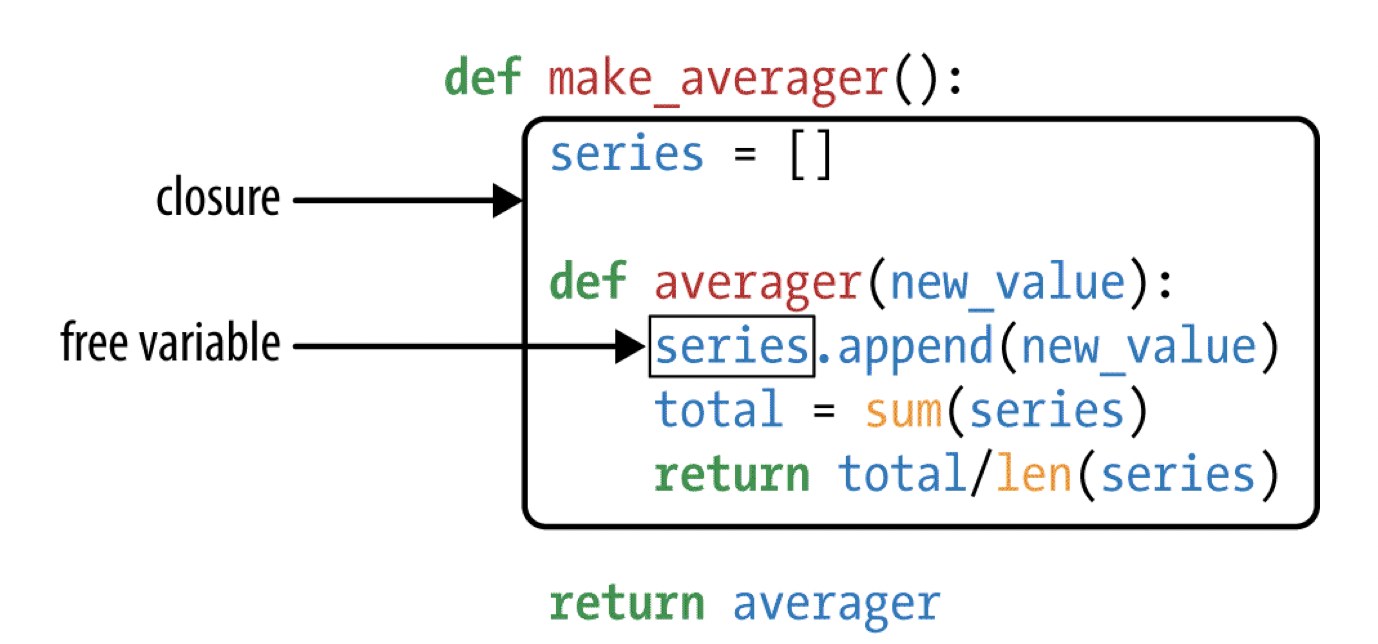

In [48]:
from IPython.display import Image
Image(filename='chapter7image.png')

In [50]:
avg.__code__.co_varnames

('new_value', 'total')

In [51]:
avg.__code__.co_freevars

('series',)

In [52]:
avg.__closure__

(<cell at 0x7f9b94f6e4f0: list object at 0x7f9b94c22ac0>,)

In [53]:
avg.__closure__[0].cell_contents

[10, 11]

**Summarize:**

* a closure is a function that retains the bindings of the free variables that exist when the function is defined, so that they can be used later whenthe function is invoked and the defining scope is no longer available. 

## The non-local Declaration 

**Example 7-13.** A broken higher-order function to calcualte a running average without keeping all history 

In [55]:
def make_averager():
    count = 0 
    total = 0
    
    def average(new_value):
        count +=1 # make it a local variable b/c it is in the body of average
        total += new_value
        return total/count 

    return average

In [56]:
avg = make_averager()

In [57]:
avg(10)

UnboundLocalError: local variable 'count' referenced before assignment

* The problem is that the statemtn count +=1 actually means the same as as count = count +1, when count is a number or any immutable type. So we are actually asigning to count in the body of averager, and that makes it a local variable. 

**Example 7-14.** Calculate a running average without keeping all history (fixed with the use of nonlocal) 

In [58]:
def make_averager():
    
    count = 0
    total = 0 
    
    def averager(new_value):
        nonlocal count, total
        count += 1
        total += new_value
        return total/count 
    
    return average

## Implementing a Simple Decorator 

**Example 7-15.** A simple decorator to output the running time of functions 

In [59]:
import time 

In [62]:
def clock(func):
    
    def clocked(*args): # Define inner function clocked to accept any number of positional arguments 
        
        t0 = time.perf_counter()
        result = func(*args) 
        elapsed = time.perf_counter() - t0
        name = func.__name__
        arg_str = ', '.join(repr(arg) for arg in args)
        print('[%0.8fs] %s(%s) --> %r' % (elapsed, name, arg_str, results))
        
        return result
    
    return clocked # Return the inner function to replace the decorated function. 

**Example 7-17.** An improved clock decorator 

In [64]:
import time 
import functools

In [66]:
def clock(func):
    
    @functools.wraps(func)
    
    def clocked(*args, **kwargs):
        t0 = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time()-t0
        name = func.__name__
        arg_lst = []
        
        if args:
            arg_lst.append(', '.join(repr(arg) for arg in args))
        
        if kwargs:
            pairs = ['%s=%r' % (k,w) for k,w in sorted(kwargs.items())]
            arg_lst.append(', '.join(pairs))
            
        arg_str = ', '.join(arg_lst)
        print('[%0.8fs] %s(%s) -> %r' %(elapsed, name,arg_str,result) )
        
        return result 
    
    return clocked 

## Stakced Decorators 

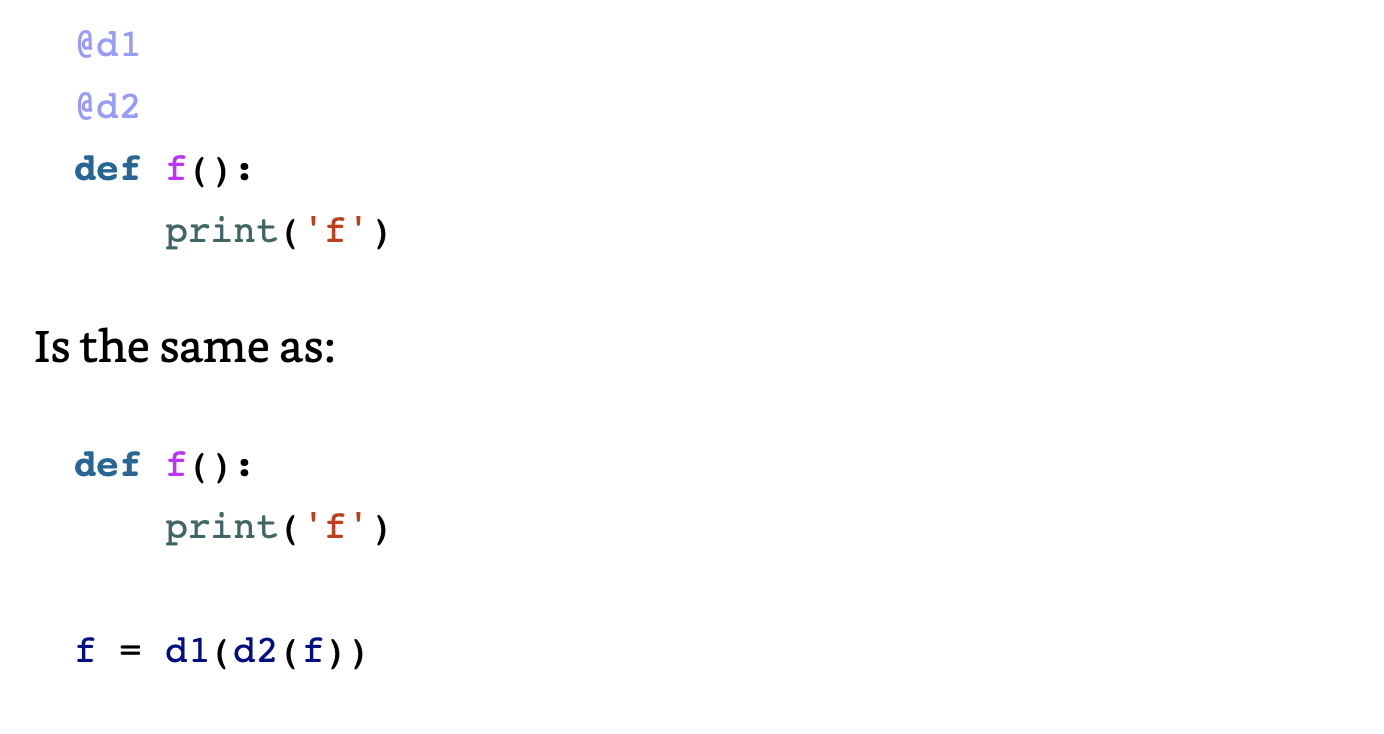

In [68]:
Image(filename='chapter7image2.png')

## Parameterized Decorators

**Example 7-22.** Abridged registrartion.py module

In [69]:
registry = []

In [70]:
def register(func):
    
    print('running register(%s)' % func)
    registry.append(func)
    return func

In [72]:
@register

def f1():
    print('running f1()')
    
print('running main()')
print('registry ->', registry)

f1()

running register(<function f1 at 0x7f9b95b95a60>)
running main()
registry -> [<function f1 at 0x7f9b95b74ee0>, <function f1 at 0x7f9b95b95a60>]
running f1()


**Example 7-23.** To accept parameter, the new register decorator must be called as a function 

In [73]:
registry = set() # registry is now a set, so adding and removing functions 
# is faster 

In [74]:
def register(active=True): # register takes an optinal keyword argument. 
    
    def decorate(func):# The decorate inner function is the actual decorator.
     # note how it takes a function as argument. 
        print('running register(active=%s)->decorate(%s)' %(active,func))
        
        if active:# Register func only if the active argument is True 
            registry.add(func)
        else:
            registry.discard(func)# If not active and func in registry, remove it
            
        return func # Because decorate is a decorator, it must return a function. 
    return decorate # register is our decorator factory, so it returns decorate
    

In [76]:
@register(active=False) # The @register factory must be invoked as a function, with the desired parameters. 

def f1():
    print('running f1()')

@register() # If no parameters are passed, register must sill be called as function 

def f2():
    print('running f2()')

def f3():
    print('running f3()')

running register(active=False)->decorate(<function f1 at 0x7f9b93965280>)
running register(active=True)->decorate(<function f2 at 0x7f9b939651f0>)
